# Consume deployed webservice via REST
Demonstrates the usage of a deployed model via plain REST.

REST is language-agnostic, so you should be able to query from any REST-capable programming language.

## Configuration

In [1]:
from environs import Env
env = Env()
env.read_env("foundation.env")
env.read_env("service-principals.env")

# image to test
IMAGE_TO_TEST = "mnist_fashion/04_consumption/random_test_images/random-test-image-1601.png"

# endpoint of the scoring webservice
SCORING_URI = "<...use your own..., eg. https://....westeurope.cloudapp.azure.com:443/api/v1/service/mnist-fashion-service/score>"

# auth method, either "Token", "Keys" or "None".
# also specify additional values depending on auth method
AUTH_METHOD = "Token"
if AUTH_METHOD == "Keys":
    AUTH_KEY = "<add your key here>"
elif AUTH_METHOD == "Token":
    REGION = "eastus"
    SUBSCRIPTION_ID = env("SUBSCRIPTION_ID")
    RESOURCE_GROUP = env("RESOURCE_GROUP")
    WORKSPACE_NAME = env("WORKSPACE_NAME")
    SERVICE_NAME = "mnist-fashion-service"
    CONSUME_MODEL_SP_TENANT_ID = env("CONSUME_MODEL_SP_TENANT_ID")
    CONSUME_MODEL_SP_CLIENT_ID = env("CONSUME_MODEL_SP_CLIENT_ID")
    CONSUME_MODEL_SP_CLIENT_SECRET = env("CONSUME_MODEL_SP_CLIENT_SECRET")
elif AUTH_METHOD == "None":
    pass

## Load a random image and plot it

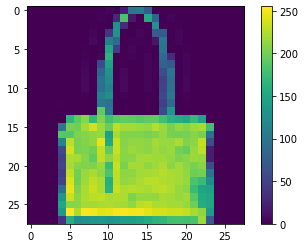

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open(IMAGE_TO_TEST)
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()

## Invoke the webservice and show result

In [3]:
import requests
import json

# --- get input data
input_data = open(IMAGE_TO_TEST, "rb").read()
# alternatively for JSON input
#input_data = json.dumps({"x": 4711})

# --- get headers
# Content-Type
# for binary data
headers = {"Content-Type": "application/octet-stream"}
# alternatively for JSON data
#headers = {"Content-Type": "application/json"}

# Authorization
if AUTH_METHOD == "Token":
    # get an access token for the service principal to access Azure
    azure_access_token = requests.post(
        f"https://login.microsoftonline.com/{CONSUME_MODEL_SP_TENANT_ID}/oauth2/token",
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        data="grant_type=client_credentials"
        + "&resource=https%3A%2F%2Fmanagement.azure.com%2F"
        + f"&client_id={CONSUME_MODEL_SP_CLIENT_ID}"
        + f"&client_secret={CONSUME_MODEL_SP_CLIENT_SECRET}",
    ).json()["access_token"]

    # use that token to get another token for accessing the webservice
    # note: the token is only valid for a certain period of time.
    #       after that time, a new token has to be used. the logic
    #       to do this, is not implemented here yet. you can check
    #       the current time against the refresh after time to know
    #       if a new token is required. refreshAfter and expiryOn
    #       are UNIX timestamps. use time.time() to get the current
    #       timestamp.
    token_response = requests.post(
        f"https://{REGION}.modelmanagement.azureml.net/modelmanagement/v1.0/subscriptions/{SUBSCRIPTION_ID}/resourceGroups/{RESOURCE_GROUP}/providers/Microsoft.MachineLearningServices/workspaces/{WORKSPACE_NAME}/services/{SERVICE_NAME}/token",
        headers={"Authorization": f"Bearer {azure_access_token}"}
    ).json()
    access_token = token_response["accessToken"]
    access_token_refresh_after = int(token_response["refreshAfter"])
    access_token_expiry_on = int(token_response["expiryOn"])

    # finally, use that token to access the webservice
    headers["Authorization"] = f"Bearer {access_token}"
if AUTH_METHOD == "Keys":
    headers["Authorization"] = f"Bearer {AUTH_KEY}"
if AUTH_METHOD == "None":
    # do nothing
    pass

# --- make request and display response
response = requests.post(SCORING_URI, input_data, headers=headers, verify=True)
print(response.json())

{'predicted_label': 'Bag', 'confidence': '1.0'}
